In [ ]:
The ubiquity of data means that combining datasets must scale better.

The ubiquity of data means that combining datasets must scale better.

In [12]:
    from .statements import get as request
    import typing as t
    import pandas, asyncio, ibis.sql.sqlite
    from toolz.curried import *

    import datetime

    from .statements import get as request
    import typing as t
    import pandas, asyncio, ibis.sql.sqlite
    from toolz.curried import *

    import datetime

# Accessing data.

Pandas has a bunch of read methods that you should fully take advantage of.

In [13]:
    pipe(pandas, dir, filter(flip(str.startswith)('read_')), list, pandas.DataFrame).T

    pipe(pandas, dir, filter(flip(str.startswith)('read_')), list, pandas.DataFrame).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,read_clipboard,read_csv,read_excel,read_feather,read_fwf,read_gbq,read_hdf,read_html,read_json,read_msgpack,read_parquet,read_pickle,read_sas,read_sql,read_sql_query,read_sql_table,read_stata,read_table


In [14]:
    frames = pandas.read_html("https://en.wikipedia.org/wiki/List_of_physical_quantities")
    f"There are __{len(frames)}__ tables in this webpage."

    frames = pandas.read_html("https://en.wikipedia.org/wiki/List_of_physical_quantities")
    f"There are __{len(frames)}__ tables in this webpage."

There are __2__ tables in this webpage.

## Caching requests

Caching our requests assures that our data remains local and we can work with out the internet.

In [15]:
    import requests_cache; requests_cache.install_cache('idiomatic_pandas')

    import requests_cache; requests_cache.install_cache('idiomatic_pandas')

In [16]:
    request??

    request??

Signature: request(url, params={}, headers={}) -> Union[pandas.core.series.Series, pandas.core.frame.DataFrame]
Docstring: `get` is asynchronous allowing data to be downloaded concurrently.
Source:   
async def get(url, params={}, headers={}) -> Union[pandas.Series, pandas.DataFrame]: 
    result = requests.get(url, params={
        **params, 'access_token': os.environ.get('gh')
    }, headers=headers).content
    try:
        return pandas.read_json(result)
    except ValueError: 
        return pandas.read_json(result, typ=pandas.Series)
File:      c:\users\deathbeds\idiomatic_pandas\idiomatic_pandas\statements.ipynb
Type:      function


> Sometimes I use Python type annotations to indicate the input and output values of the functions.

In [17]:
    username = 'tonyfast'

    username = 'tonyfast'

In [18]:
    info = await request(f"https://api.github.com/users/%s"%username); info.to_frame()

    info = await request(f"https://api.github.com/users/%s"%username); info.to_frame()

,0
login,tonyfast
id,4236275
node_id,MDQ6VXNlcjQyMzYyNzU=
avatar_url,https://avatars3.githubusercontent.com/u/42362...
gravatar_id,
url,https://api.github.com/users/tonyfast
html_url,https://github.com/tonyfast
followers_url,https://api.github.com/users/tonyfast/followers
following_url,https://api.github.com/users/tonyfast/followin...
gists_url,https://api.github.com/users/tonyfast/gists{/g...


## Some utitlity statements.

Accessing historical data in github requires pagination. https://developer.github.com/v3/guides/traversing-with-pagination/

`paginate` appends `"?page=%i"` to the end of our Github API requests.

In [19]:
    def paginate(url: str, slice: slice=slice(1,3)) -> t.Generator:
        return (f"{url}?page={page}" for page in range(slice.start, slice.stop+1))

    def paginate(url: str, slice: slice=slice(1,3)) -> t.Generator:
        return (f"{url}?page={page}" for page in range(slice.start, slice.stop+1))

I don't have `datetime` for composing timestamps so I use `pandas.to_datetime`

In [20]:
    def timify(df):
        at = [str for str in df.columns if str.endswith('_at')]
        df[at] = df[at].apply(pandas.to_datetime)        
        return df

    def timify(df):
        at = [str for str in df.columns if str.endswith('_at')]
        df[at] = df[at].apply(pandas.to_datetime)        
        return df

In [23]:
`pandas.to_timedelta` helps with Δt.

------> pandas.to_timedelta


<function pandas.core.tools.timedeltas.to_timedelta(arg, unit='ns', box=True, errors='raise')>

In [24]:
    pandas.to_timedelta('1 days 10 seconds')

    pandas.to_timedelta('1 days 10 seconds')

Timedelta('1 days 00:00:10')

In [28]:
and the difference between timestamps returns a time delta.

and the difference between timestamps returns a time delta.

In [38]:
    Δt = pandas.Series([info.created_at, info.updated_at]).pipe(pandas.to_datetime).diff().dropna(); Δt

    Δt = pandas.Series([info.created_at, info.updated_at]).pipe(pandas.to_datetime).diff().dropna(); Δt

1   1987 days 02:19:37
dtype: timedelta64[ns]

## Let's talk about me

In [49]:
    repos = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.repos_url, slice(1, info.public_repos//30+1))))
    ).set_index('id').pipe(timify)
    f"""I have __{len(repos)}__ repositories associated with my account after __>{Δt[1].days//365}__ years."""

    repos = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.repos_url, slice(1, info.public_repos//30+1))))
    ).set_index('id').pipe(timify)
    f"""I have __{len(repos)}__ repositories associated with my account after __>{Δt[1].days//365}__ years."""

I have __156__ repositories associated with my account after __>5__ years.

In [50]:
    gists = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.gists_url.format(**{'/gist_id': ''}), slice(1, info.public_gists//30+1))
        ))
    ).set_index('id').pipe(timify)
    f"""I've made __{len(gists)}__ gists during that time."""

    gists = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.gists_url.format(**{'/gist_id': ''}), slice(1, info.public_gists//30+1))
        ))
    ).set_index('id').pipe(timify)
    f"""I've made __{len(gists)}__ gists during that time."""

I've made __513__ gists during that time.

In [52]:
    stars = pandas.concat(
        await asyncio.gather(*map(
            partial(request, headers={
                'Accept': "application/vnd.github.v3.star+json"
            }), paginate(
                info.starred_url.format(**{'/owner': '', '/repo': ''}), slice(1, 700//30+1))
        ))
    ).pipe(
        lambda df: pandas.concat([df.repo.apply(pandas.Series), df.starred_at], axis=1)
    ).pipe(timify).set_index('id')
    f"""I've starred __{len(stars)}__ repositories, too."""

    stars = pandas.concat(
        await asyncio.gather(*map(
            partial(request, headers={
                'Accept': "application/vnd.github.v3.star+json"
            }), paginate(
                info.starred_url.format(**{'/owner': '', '/repo': ''}), slice(1, 700//30+1))
        ))
    ).pipe(
        lambda df: pandas.concat([df.repo.apply(pandas.Series), df.starred_at], axis=1)
    ).pipe(timify).set_index('id')
    f"""I've starred __{len(stars)}__ repositories, too."""

I've starred __700__ repositories, too.

In [55]:
    events = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.events_url.format(**{'/privacy': ''}), slice(1, 10))))
    ).set_index('id').pipe(timify)

    events = pandas.concat(
        await asyncio.gather(*map(
            request, paginate(info.events_url.format(**{'/privacy': ''}), slice(1, 10))))
    ).set_index('id').pipe(timify)

In [59]:
    %matplotlib inline

    %matplotlib inline

    events.type.value_counts().plot.pie()
    f"""A look at __{username}'s__ last __300__ events.'"""

A look at __tonyfast's__ last __300__ events.'

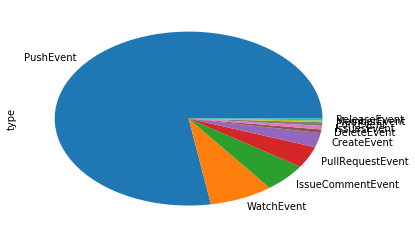

In [67]:
    events.type.value_counts().plot.pie()
    f"""A look at __{username}'s__ last __300__ events.'"""

In [75]:
    from matplotlib_venn import *; from toolz.curried.operator import *

    from matplotlib_venn import *; from toolz.curried.operator import *

    pipe((repos, gists, stars), map(attrgetter('columns')), map(set), list, 
         partial(venn3_unweighted, set_labels=('repos', 'gists', 'stars')))

    intersections = set(repos.columns).intersection(gists.columns).intersection(stars.columns)
    f"The __{len(intersections)}__ overlapping columns are: __{', '.join(intersections)}__"

The __10__ overlapping columns are: __updated_at, url, created_at, description, forks_url, html_url, comments_url, owner, node_id, commits_url__

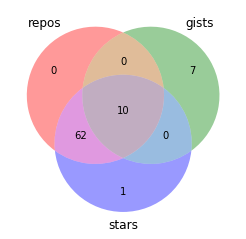

In [95]:
    pipe((repos, gists, stars), map(attrgetter('columns')), map(set), list, 
         partial(venn3_unweighted, set_labels=('repos', 'gists', 'stars')))

    intersections = set(repos.columns).intersection(gists.columns).intersection(stars.columns)
    f"The __{len(intersections)}__ overlapping columns are: __{', '.join(intersections)}__"

## Aggregations

`pandas.DataFrame.groupby` & `pandas.DataFrame.rolling` aggreations

In [156]:
    monthly_actions = repos.set_index('created_at')[[]].join(
        gists.set_index('created_at')[[]]
    ).join(
        stars.set_index('created_at')[[]]
    ).sort_index().index.to_frame().groupby(
        pandas.Grouper(freq='M')
    ).count()['created_at'].rename('created')

    monthly_actions = repos.set_index('created_at')[[]].join(
        gists.set_index('created_at')[[]]
    ).join(
        stars.set_index('created_at')[[]]
    ).sort_index().index.to_frame().groupby(
        pandas.Grouper(freq='M')
    ).count()['created_at'].rename('created')

    ax = monthly_actions.plot(title='Events per month', legend=True)

    monthly_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True, grid=True)

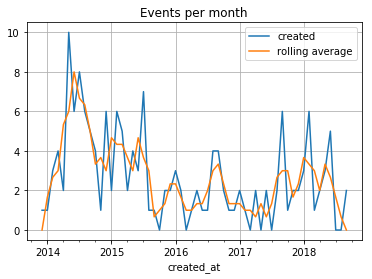

In [155]:
    ax = monthly_actions.plot(title='Events per month', legend=True)
    monthly_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True, grid=True)

    this_years_actions = monthly_actions[monthly_actions.index > pandas.to_datetime('2018-04-01')]
    ax = this_years_actions.plot(title='Events per month', legend=True, figsize=(24, 8), grid=True)
    this_years_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True)
    events.set_index('created_at').index.to_frame().groupby(
        pandas.Grouper(freq='1D')
    ).count()['created_at'].rename('minor events').plot(ax=ax, legend=True, grid=True)

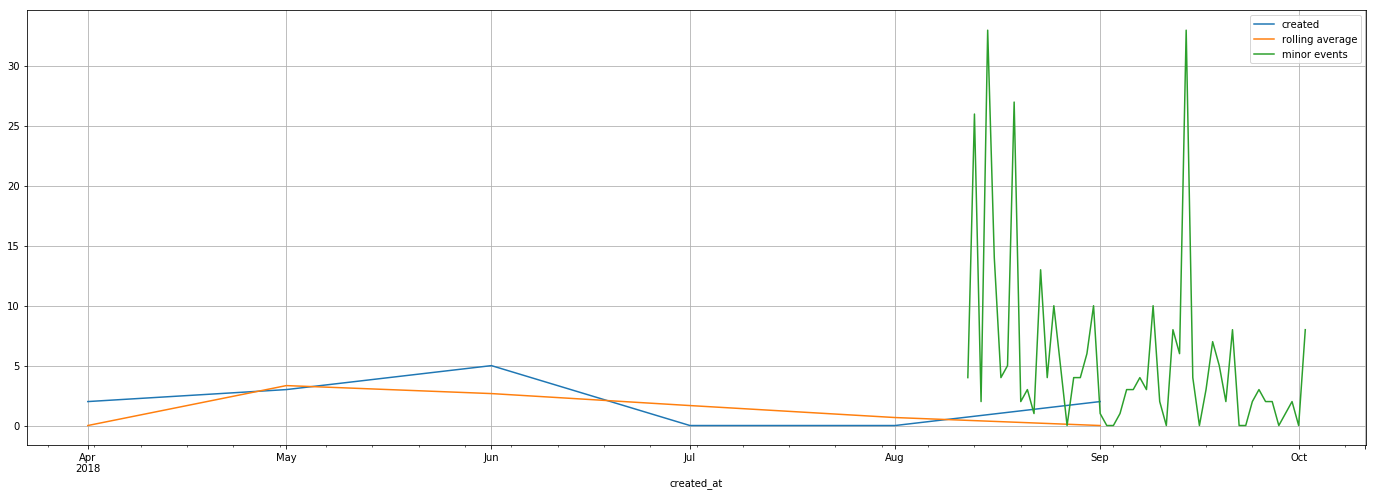

In [154]:
    this_years_actions = monthly_actions[monthly_actions.index > pandas.to_datetime('2018-04-01')]
    ax = this_years_actions.plot(title='Events per month', legend=True, figsize=(24, 8), grid=True)
    this_years_actions.rolling(3, center=True).mean().rename('rolling average').fillna(0).plot(ax=ax, legend=True)
    events.set_index('created_at').index.to_frame().groupby(
        pandas.Grouper(freq='1D')
    ).count()['created_at'].rename('minor events').plot(ax=ax, legend=True, grid=True)

In [11]:
# ✋✋✋✋✋✋✋✋

I'm [Tony Fast]().  I organize [PyData Atlanta]() and the [Jupyter User Group]().  I am currently interested in composing human readable programs
using notebooks.

I'm going to tell you a little bit about myself in data.  Then we will dissect my approach.

In [1]:
    from . import readme as ˣ

    from . import readme as ˣ

In [2]:
    import pandas; "Explicit is better than implicit.";

    import pandas; "Explicit is better than implicit.";

In [3]:
    import os; os.environ.get('gh'); params = {'access_token': os.environ.get('gh')}

    import os; os.environ.get('gh'); params = {'access_token': os.environ.get('gh')}

In [4]:
    gh = f"https://api.github.com/users/%s"

    gh = f"https://api.github.com/users/%s"

In [5]:
    info = pandas.read_json(gh%'tonyfast', typ=pandas.Series)

    info = pandas.read_json(gh%'tonyfast', typ=pandas.Series)

In [6]:
    f"![]({info.avatar_url})"

    f"![]({info.avatar_url})"

![](https://avatars3.githubusercontent.com/u/4236275?v=4)

In [7]:
    info.gists_url = info.gists_url.format(**{'/gist_id': '?page=%i'})
    info.to_frame().T.set_index('login').T

    info.gists_url = info.gists_url.format(**{'/gist_id': '?page=%i'})
    info.to_frame().T.set_index('login').T

login,tonyfast
id,4236275
node_id,MDQ6VXNlcjQyMzYyNzU=
avatar_url,https://avatars3.githubusercontent.com/u/42362...
gravatar_id,
url,https://api.github.com/users/tonyfast
html_url,https://github.com/tonyfast
followers_url,https://api.github.com/users/tonyfast/followers
following_url,https://api.github.com/users/tonyfast/followin...
gists_url,https://api.github.com/users/tonyfast/gists?pa...
starred_url,https://api.github.com/users/tonyfast/starred{...


In [8]:
    f"""There are {info.public_gists} gists."""

    f"""There are {info.public_gists} gists."""

There are 513 gists.

In [10]:
Let's grab one of them.

Let's grab one of them.

The gists have datetime values in them.  I prefer the `pandas.to_datetime` function over native datetime objects.  This approach saves effort in importing and using a different api.  

In [10]:
    def timify(df):
        at = [str for str in df.columns if str.endswith('_at')]
        df[at] = df[at].apply(pandas.to_datetime)        
        return df

    def timify(df):
        at = [str for str in df.columns if str.endswith('_at')]
        df[at] = df[at].apply(pandas.to_datetime)        
        return df

In [12]:
    %%time
    gist = pandas.read_json(info.gists_url%1 + "?access_token={os.environ['gh']}").pipe(timify).set_index('id')

    %%time
    gist = pandas.read_json(info.gists_url%1 + "?access_token={os.environ['gh']}").pipe(timify).set_index('id')

Wall time: 523 ms


In [13]:
    f"Each request returns {len(gist)} gists, but I have {info.public_gists} gists."

    f"Each request returns {len(gist)} gists, but I have {info.public_gists} gists."

Each request returns 30 gists, but I have 513 gists.

## Caching

Your research data should be local.  You should be able to work without the internet.  Caching decreases lag and entropy while experiencing a dataset.

[`requests_cache`](https://github.com/reclosedev/requests-cache)

In [135]:
    import requests_cache, requests, asyncio; requests_cache.install_cache('idiomatic_pandas')

    import requests_cache, requests, asyncio; requests_cache.install_cache('idiomatic_pandas')

In [115]:
    async def aget(url, **headers): return pandas.DataFrame(requests.get(url, params=params, headers=headers).json())

    async def aget(url, **headers): return pandas.DataFrame(requests.get(url, params=params, headers=headers).json())

In [116]:
    df = pandas.concat(
        await asyncio.gather(*(
            aget(info.gists_url%int) 
            for int in range(1, (info.public_gists//30)+2)))).pipe(timify).set_index('id')
    df.info()

    df = pandas.concat(
        await asyncio.gather(*(
            aget(info.gists_url%int) 
            for int in range(1, (info.public_gists//30)+2)))).pipe(timify).set_index('id')
    df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 06a797f15ad4c32ab9627a68af92f7f8 to 10420967
Data columns (total 17 columns):
comments        513 non-null int64
comments_url    513 non-null object
commits_url     513 non-null object
created_at      513 non-null datetime64[ns]
description     503 non-null object
files           513 non-null object
forks_url       513 non-null object
git_pull_url    513 non-null object
git_push_url    513 non-null object
html_url        513 non-null object
node_id         513 non-null object
owner           513 non-null object
public          513 non-null bool
truncated       513 non-null bool
updated_at      513 non-null datetime64[ns]
url             513 non-null object
user            0 non-null object
dtypes: bool(2), datetime64[ns](2), int64(1), object(12)
memory usage: 65.1+ KB


In [117]:
    files = (
        df.files
        .apply(pandas.Series)
        .stack()
        .apply(pandas.Series)
        .reset_index(1, drop=True)
    ).join(df)

    files = (
        df.files
        .apply(pandas.Series)
        .stack()
        .apply(pandas.Series)
        .reset_index(1, drop=True)
    ).join(df)

In [118]:
    files.info()

    files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 008034d9bac504e33f7e2fe146de52f5 to ffef6679a86dfd89015f757d8537f7b1
Data columns (total 22 columns):
filename        714 non-null object
type            714 non-null object
language        673 non-null object
raw_url         714 non-null object
size            714 non-null int64
comments        714 non-null int64
comments_url    714 non-null object
commits_url     714 non-null object
created_at      714 non-null datetime64[ns]
description     695 non-null object
files           714 non-null object
forks_url       714 non-null object
git_pull_url    714 non-null object
git_push_url    714 non-null object
html_url        714 non-null object
node_id         714 non-null object
owner           714 non-null object
public          714 non-null bool
truncated       714 non-null bool
updated_at      714 non-null datetime64[ns]
url             714 non-null object
user            0 non-null object
dtypes: bool(2), datetime64[ns](2), int6

In [119]:
    files.sample(2)

    files.sample(2)

,filename,type,language,raw_url,size,comments,comments_url,commits_url,created_at,description,...,git_pull_url,git_push_url,html_url,node_id,owner,public,truncated,updated_at,url,user
id,,,,,,,,,,,,,,,,,,,,,
259be104bee24babb84104d0d615f3be,gistfile1.txt,text/plain,Text,https://gist.githubusercontent.com/tonyfast/25...,154,0,https://api.github.com/gists/259be104bee24babb...,https://api.github.com/gists/259be104bee24babb...,2018-04-30 04:16:42,,...,https://gist.github.com/259be104bee24babb84104...,https://gist.github.com/259be104bee24babb84104...,https://gist.github.com/259be104bee24babb84104...,MDQ6R2lzdDI1OWJlMTA0YmVlMjRiYWJiODQxMDRkMGQ2MT...,"{'login': 'tonyfast', 'id': 4236275, 'node_id'...",True,False,2018-04-30 04:16:42,https://api.github.com/gists/259be104bee24babb...,None
13c3690eb139b8b08fc8,conways-game-of-life.ipynb,text/plain,Jupyter Notebook,https://gist.githubusercontent.com/tonyfast/13...,21944,0,https://api.github.com/gists/13c3690eb139b8b08...,https://api.github.com/gists/13c3690eb139b8b08...,2015-11-04 02:28:48,Conways game of life code kata for PyAtl,...,https://gist.github.com/13c3690eb139b8b08fc8.git,https://gist.github.com/13c3690eb139b8b08fc8.git,https://gist.github.com/13c3690eb139b8b08fc8,MDQ6R2lzdDEzYzM2OTBlYjEzOWI4YjA4ZmM4,"{'login': 'tonyfast', 'id': 4236275, 'node_id'...",True,False,2017-05-18 06:23:59,https://api.github.com/gists/13c3690eb139b8b08fc8,None


In [120]:
    languages = files.set_index('created_at').language.groupby(pandas.Grouper(freq='M')).value_counts().unstack().fillna(0)

    languages = files.set_index('created_at').language.groupby(pandas.Grouper(freq='M')).value_counts().unstack().fillna(0)

## Ranking the orders

In [121]:
    languages = languages[languages.sum().sort_values(ascending=False).index]

    languages = languages[languages.sum().sort_values(ascending=False).index]

In [121]:
Plotting style is influenced by the structured of the dataframe

Plotting style is influenced by the structured of the dataframe

    %matplotlib inline
    montly = languages.iloc[:, :6].join(languages.iloc[:, 6:].sum(axis=1).rename('other'))
    ax = montly.plot(figsize=(12,6))
    montly.sum(axis=1).rename('total files').to_frame().plot(style='--', ax=ax);

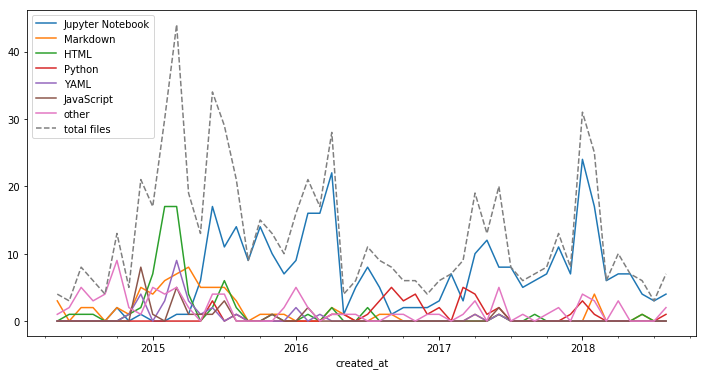

In [122]:
    %matplotlib inline
    montly = languages.iloc[:, :6].join(languages.iloc[:, 6:].sum(axis=1).rename('other'))
    ax = montly.plot(figsize=(12,6))
    montly.sum(axis=1).rename('total files').to_frame().plot(style='--', ax=ax);

    montly = languages.iloc[:, :6].join(languages.iloc[:, 6:].sum(axis=1).rename('other')).cumsum().plot(figsize=(12,6))

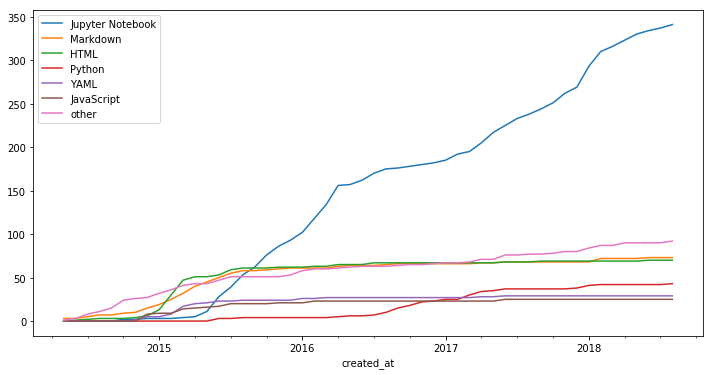

In [123]:
    montly = languages.iloc[:, :6].join(languages.iloc[:, 6:].sum(axis=1).rename('other')).cumsum().plot(figsize=(12,6))

In [124]:
    info.events_url = info.events_url.format(**{'/privacy': '?page=%i'})

    info.events_url = info.events_url.format(**{'/privacy': '?page=%i'})

https://developer.github.com/v3/activity/events/

https://developer.github.com/v3/activity/events/

In [127]:
    events = pandas.concat(
        await asyncio.gather(*(
            aget(info.events_url%int) 
            for int in range(1, 11)))).pipe(timify).set_index('id')
    events.info()

    events = pandas.concat(
        await asyncio.gather(*(
            aget(info.events_url%int) 
            for int in range(1, 11)))).pipe(timify).set_index('id')
    events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 8344351425 to 8073658386
Data columns (total 7 columns):
actor         300 non-null object
created_at    300 non-null datetime64[ns]
org           275 non-null object
payload       300 non-null object
public        300 non-null bool
repo          300 non-null object
type          300 non-null object
dtypes: bool(1), datetime64[ns](1), object(5)
memory usage: 16.7+ KB


In [128]:
    events.join(events.repo.apply(lambda x: x['name']).rename('target'));

    events.join(events.repo.apply(lambda x: x['name']).rename('target'));

In [129]:

    info.starred_url = info.starred_url.format(**{'/owner': '?page=%i', '/repo': ''})

In [131]:
    ls *.sqlite

    ls *.sqlite

 Volume in drive C is Local Disk
 Volume Serial Number is B0F0-33DE

 Directory of C:\Users\deathbeds\idiomatic_pandas\idiomatic_pandas

10/01/2018  01:02 PM         5,816,320 idiomatic_pandas.sqlite
               1 File(s)      5,816,320 bytes
               0 Dir(s)  175,370,022,912 bytes free


In [144]:
    stars = pandas.concat(
        await asyncio.gather(*(
            aget(info.starred_url%int, Accept="application/vnd.github.v3.star+json") 
            for int in range(1, (700//30)+2)))
    ).pipe(timify).pipe(
        lambda df: df.repo.apply(pandas.Series).join(df.starred_at)
    )
    stars.info()

    stars = pandas.concat(
        await asyncio.gather(*(
            aget(info.starred_url%int, Accept="application/vnd.github.v3.star+json") 
            for int in range(1, (700//30)+2)))
    ).pipe(timify).pipe(
        lambda df: df.repo.apply(pandas.Series).join(df.starred_at)
    )
    stars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16340 entries, 0 to 29
Data columns (total 74 columns):
id                   16340 non-null int64
node_id              16340 non-null object
name                 16340 non-null object
full_name            16340 non-null object
private              16340 non-null bool
owner                16340 non-null object
html_url             16340 non-null object
description          15869 non-null object
fork                 16340 non-null bool
url                  16340 non-null object
forks_url            16340 non-null object
keys_url             16340 non-null object
collaborators_url    16340 non-null object
teams_url            16340 non-null object
hooks_url            16340 non-null object
issue_events_url     16340 non-null object
events_url           16340 non-null object
assignees_url        16340 non-null object
branches_url         16340 non-null object
tags_url             16340 non-null object
blobs_url            16340 non-null obj

    stars.set_index('starred_at')['language'].groupby(
        pandas.Grouper(freq='3M')
    ).value_counts().unstack().fillna(0).pipe(
        lambda df: df[df.sum().sort_values(ascending=False).index]
    ).pipe(
        lambda df: pandas.concat([df.iloc[:, :10], df.iloc[:, 10:].sum(axis=1).rename('other')], axis=1)
    ).plot()

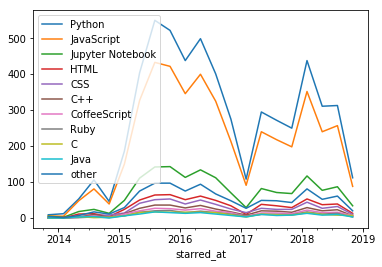

In [179]:
    stars.set_index('starred_at')['language'].groupby(
        pandas.Grouper(freq='3M')
    ).value_counts().unstack().fillna(0).pipe(
        lambda df: df[df.sum().sort_values(ascending=False).index]
    ).pipe(
        lambda df: pandas.concat([df.iloc[:, :10], df.iloc[:, 10:].sum(axis=1).rename('other')], axis=1)
    ).plot()

    stars.set_index('starred_at')['language'].groupby(
        pandas.Grouper(freq='3M')
    ).value_counts().unstack().fillna(0).pipe(
        lambda df: df[df.sum().sort_values(ascending=False).index]
    ).pipe(
        lambda df: pandas.concat([df.iloc[:, :10], df.iloc[:, 10:].sum(axis=1).rename('other')], axis=1)
    ).plot()

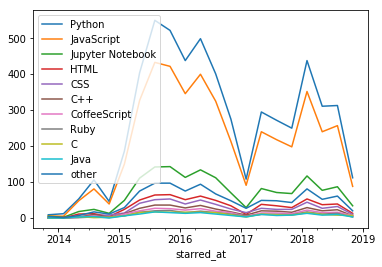

In [183]:
    stars.set_index('starred_at')['language'].groupby(
        pandas.Grouper(freq='3M')
    ).value_counts().unstack().fillna(0).pipe(
        lambda df: df[df.sum().sort_values(ascending=False).index]
    ).pipe(
        lambda df: pandas.concat([df.iloc[:, :10], df.iloc[:, 10:].sum(axis=1).rename('other')], axis=1)
    ).plot()